# ALPHA SCRIPT

This script combines all the steps so that it runs automatically

In [1]:
import os
import io
import json
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import shutil
from glob import glob
from noisi.util.setup_data_gaussgrid import setup_data_gaussgrid
from noisi.scripts.source_grid_gauss import gauss_grid
from noisi.util.setup_noisesource_new import setup_noisesource_new
from noisi.util.plot_with_azimuth_sel import plot_section
from noisi.util.make_synthetic_data import make_synth_data
from noisi.util.plot_cartopy import plot_gradient

NOISI toolkit
Python version: 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:44:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
mpi4py version: 3.0.0
/Users/jigel/noisi/noisi


In [2]:
# First step: Input
# Make a config file for this

project_name = "Fabrice_10s_ALPHA_TEST"

# data input
data_path = "./WW3-GLOB-30M_201701_p2l.nc"
t_data = 72
f_dom = 1/10
data_thresh = 0.04
gamma_thresh = 8
extent = [-90,90,0,90]

# grid input
gamma_const = 3
back_grid_phi = 3
data_grid_phi = 0.4

# station list input
stationlist_path = "./stationlist_atlantic_26.csv"

# wavefield input
wavefield_path = "../axisem/SOLVER/Noisi_10s_repacked/"


In [3]:
# Setup new project
os.system('noisi setup_project ' + project_name)
print('New project created:', project_name)

project_path = os.path.join(os.getcwd(),"Alpha_Project")
print('Path to new project: ', project_path)

# copy stationlist file to project and rename stationlist.csv
os.system ('cp {} {}'.format(stationlist_path,os.path.join(project_path,'stationlist.csv')))
print ('Copied stationlist file to project directory.')

New project created: Alpha_Project
Path to new project:  /Users/jigel/noisi/Alpha_Project
Copied stationlist file to project directory.


In [4]:
# Setup the grid
# Need to make variables for how dense additional grids are

sigma,beta,phi_ini,phi_max,lat_0,lon_0,n,gamma = setup_data_gaussgrid(project_path,data_path,t_data,f_dom,data_thresh,gamma_thresh,gamma_const,back_grid_phi,data_grid_phi,extent,plot=False)

plot = False
only_ocean = True
dense_antipole = False

# Adjust so it can be written to config file
lat_0 = [float(i) for i in lat_0]
lon_0 = [float(i) for i in lon_0]

# Write to config.json file
config_path = os.path.join(project_path,'config.json')


with io.open(config_path,'r+') as fh:
        conf = json.loads(fh.read())
        
conf['gauss_grid'] = True      
conf['gauss_sigma'] = sigma
conf['gauss_beta'] = beta
conf['gauss_phi_ini'] = phi_ini
conf['gauss_phi_max'] = phi_max
conf['gauss_lat_0'] = lat_0
conf['gauss_lon_0'] = lon_0
conf['gauss_n'] = n
conf['gauss_gamma'] = gamma
conf['gauss_plot'] = plot
conf['gauss_dense_antipole'] = dense_antipole
conf['gauss_only_ocean'] = only_ocean

# Set below to true if voronoi cell surface area is to be calculated
conf['voronoi_surface_area'] = True

# change instaseis and wavefield
conf['instaseis'] = True
conf['wavefield_path'] = os.path.abspath(wavefield_path)

with io.open(config_path,'w') as fh:
    cf = json.dumps(conf,sort_keys=False, indent=4, separators=(",", ": "))
    fh.write(cf)

    


Number of gridpoints above threshold:  3295
Number of additional grids: 6


In [5]:
# calculate grid with noisi
print('Computing grid...')
os.system('noisi setup_sourcegrid ' + project_path)
print('Grid computed and saved as sourcegrid.npy')

Computing grid...
Grid computed and saved as sourcegrid.npy


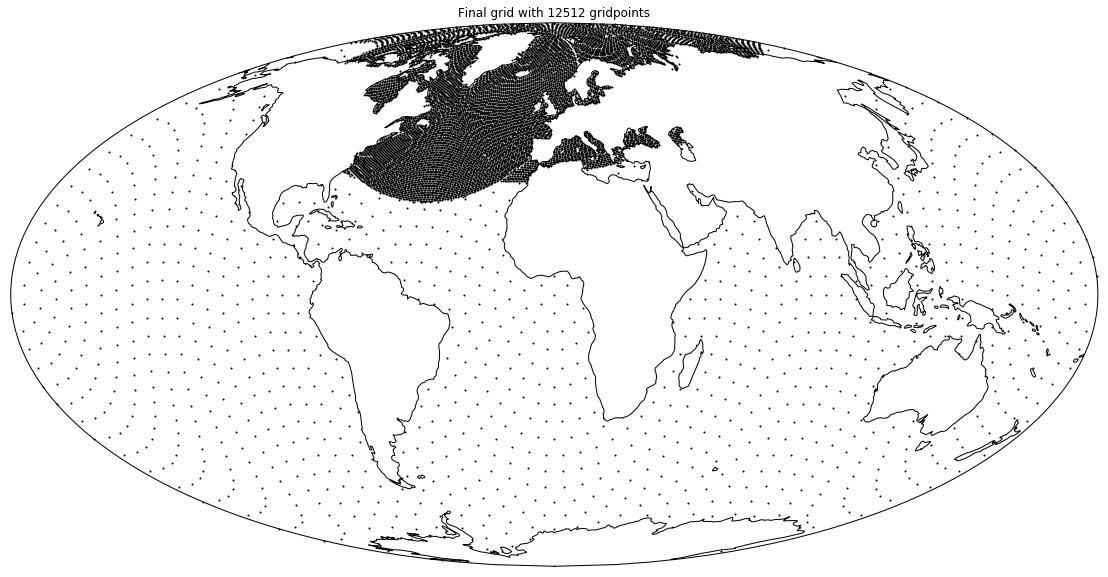

In [6]:
# Plot and save sourcegrid
sourcegrid_path = os.path.join(project_path,'sourcegrid.npy')
grid = np.load(sourcegrid_path)

plt.figure(figsize=(25,10))
ax = plt.axes(projection=ccrs.Mollweide())
ax.coastlines()
plt.scatter(grid[0],grid[1],s=1,c='k',transform=ccrs.Geodetic())
plt.title('Final grid with {} gridpoints'.format(np.size(grid[0])))
plt.savefig(os.path.join(project_path,"sourcegrid.png"))
plt.show()

In [7]:
# Setup a homogeneous source called homo_source
source_homo = "homo_source"

source_homo_path = os.path.join(project_path,source_homo)
os.system ('noisi setup_source ' + source_homo_path)

print('New source created: ', source_homo_path)

New source created:  /Users/jigel/noisi/Alpha_Project/homo_source


In [8]:
# Get number of stations for mpi
stationlist = read_csv(stationlist_path)
station_n = np.shape(stationlist)[0]
print('Number of stations: ',station_n)

Number of stations:  26


In [9]:
# Convert wavefield 
# need arguments: source_config, config, sourcegrid, stationlist, output folder

source_config_path = os.path.join(source_homo_path,'source_config.json')
wavefield_from_instaseis_path = os.path.join(source_homo_path,'wavefield_from_instaseis.py')

print('Converting wavefield from instaseis...')
os.system('mpirun -np {} python {} {} {} {} {} {}'.format(station_n,wavefield_from_instaseis_path,source_config_path,config_path,sourcegrid_path,stationlist_path,project_path))
print('Done.')

Converting wavefield from instaseis...
Done.


In [10]:
wavefield_processed_path = os.path.join(project_path,'wavefield_processed')

# Change config.json file
with io.open(config_path,'r+') as fh:
        conf = json.loads(fh.read())

# change instaseis and wavefield
conf['instaseis'] = False
conf['wavefield_path'] = os.path.abspath(wavefield_processed_path)

with io.open(config_path,'w') as fh:
    cf = json.dumps(conf,sort_keys=False, indent=4, separators=(",", ": "))
    fh.write(cf)

In [11]:
# Change source_config file
source_config_path = os.path.join(source_homo_path,'source_config.json')

with io.open(source_config_path,'r+') as fh:
        conf = json.loads(fh.read())

# change instaseis and wavefield
conf['max_lag'] = 2500
conf['preprocess_do'] = False
conf ['project_name'] = project_name
conf ['project_path'] = project_path
with io.open(source_config_path,'w') as fh:
    cf = json.dumps(conf,sort_keys=False, indent=4, separators=(",", ": "))
    fh.write(cf)

Setting up noisesource distribution...
Number of gridpoints:  12512
<HDF5 file "UP.ROTU..MXZ.h5" (mode r)>
df = 1.0 nt =  4953 n =  10000
freq_min =  0.0 freq_max =  0.5
Getting ocean mask...
Latitude from -90.0 to 89.85,
        Longitude from -180.0 to 180.0


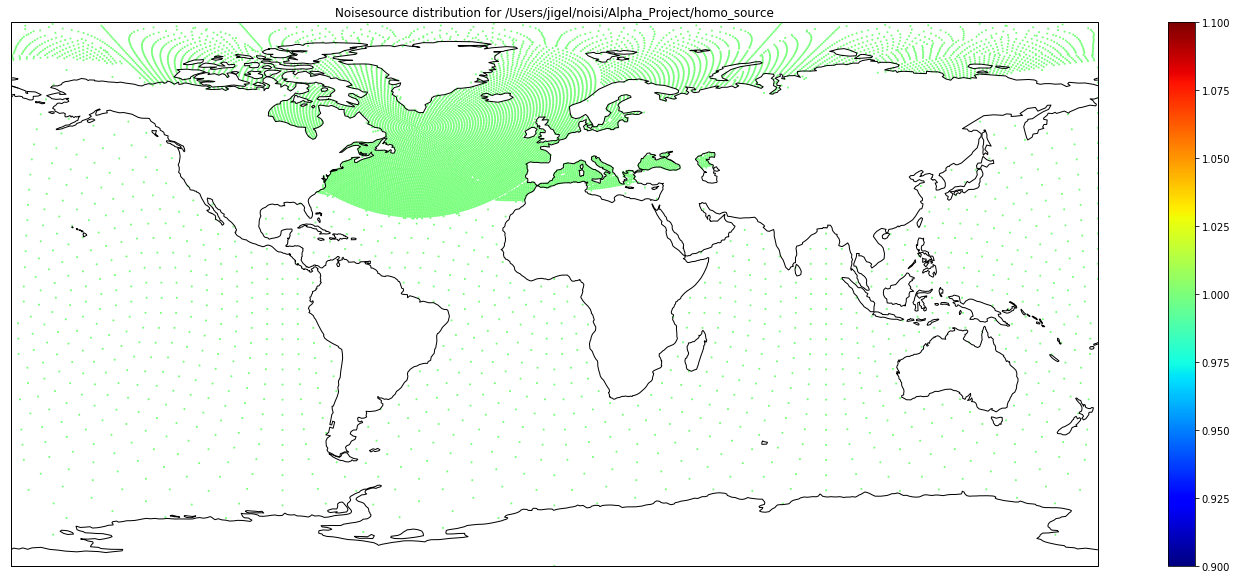

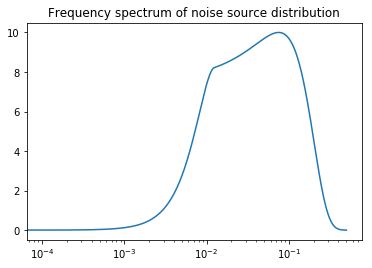

Number of grids:  7
Grid 1 of 7
Grid 2 of 7
Grid 3 of 7
Grid 4 of 7
Grid 5 of 7
Grid 6 of 7
Grid 7 of 7
0 of 23247 voronoi cell surface areas calculated.
1000 of 23247 voronoi cell surface areas calculated.
2000 of 23247 voronoi cell surface areas calculated.
3000 of 23247 voronoi cell surface areas calculated.
4000 of 23247 voronoi cell surface areas calculated.
5000 of 23247 voronoi cell surface areas calculated.
6000 of 23247 voronoi cell surface areas calculated.
7000 of 23247 voronoi cell surface areas calculated.
8000 of 23247 voronoi cell surface areas calculated.
9000 of 23247 voronoi cell surface areas calculated.
10000 of 23247 voronoi cell surface areas calculated.
11000 of 23247 voronoi cell surface areas calculated.
12000 of 23247 voronoi cell surface areas calculated.
13000 of 23247 voronoi cell surface areas calculated.
14000 of 23247 voronoi cell surface areas calculated.
15000 of 23247 voronoi cell surface areas calculated.
16000 of 23247 voronoi cell surface areas cal

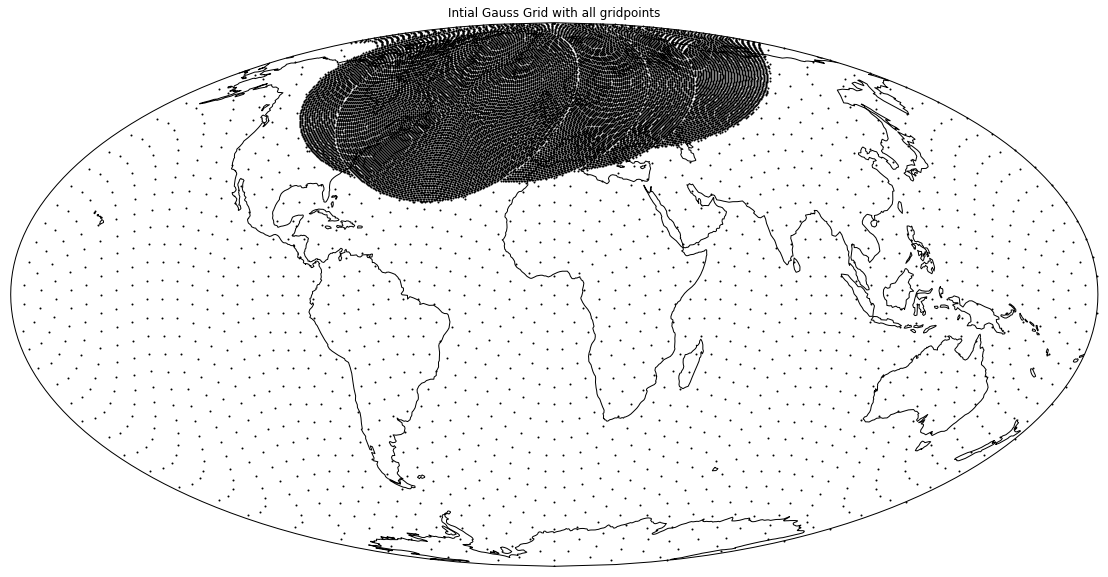

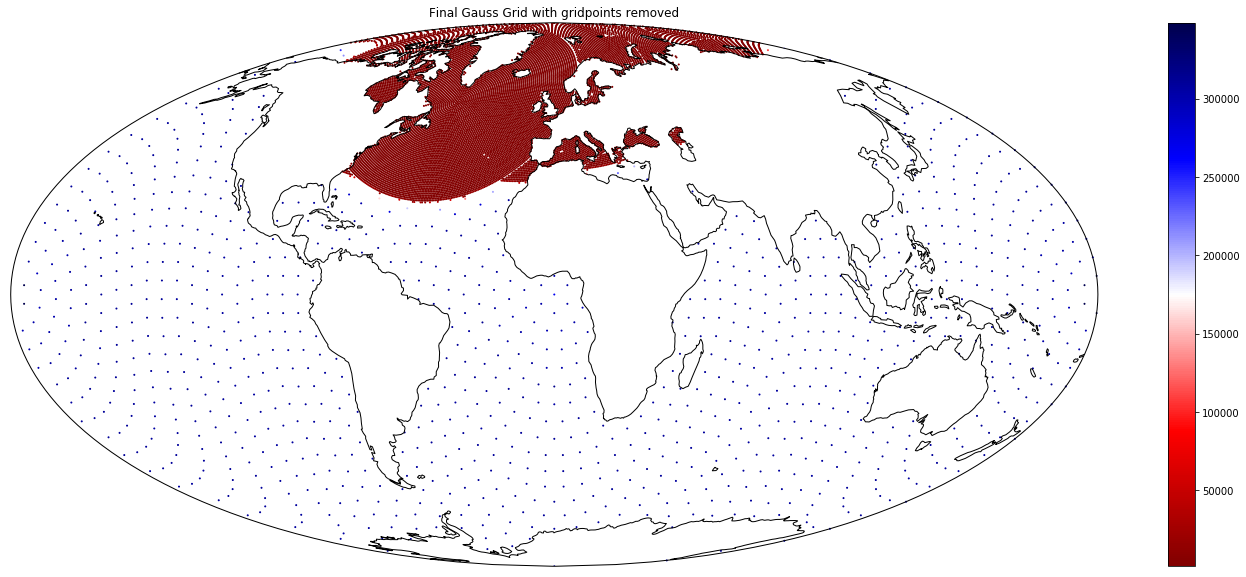

Gridpoints and voronoi cells on land removed.
Final number of gridpoints: 12512
Done.


In [12]:
# setup noise source for homogeneous model

print('Setting up noisesource distribution...')
setup_noisesource_new(project_path,source_homo_path)
print('Done.')

In [14]:
# calculate correlations for homogeneous source
print("Computing correlations...")
os.system("mpirun -np 8 noisi correlation {} {}".format(source_homo_path,0))
print("All correlations computed.")

Computing correlations...
All correlations computed.


/Users/jigel/noisi/Alpha_Project/homo_source/step_0/corr
Found traces:

/Users/jigel/noisi/Alpha_Project/homo_source/step_0/corr/GB.CWF..MXZ--GE.VAL..MXZ.sac
...to...
/Users/jigel/noisi/Alpha_Project/homo_source/step_0/corr/DK.MUD..MXZ--NS.FOO..MXZ.sac
Assign geographical information.

CWF VAL
52.7383 -1.30722 51.9394 -10.2442
UDBI UDBI
44.5279 15.7644 44.5279 15.7644
BIGH CWF
58.4933 -3.9105 52.7383 -1.30722
FRB SFJD
63.7469 -68.5451 66.9961 -50.62076
DRUM CLL
56.9126 -2.4865 51.30769 13.00261
CWF SOFL
52.7383 -1.30722 62.0689 -6.9658
MONQ VAL
44.3676 1.1953 51.9394 -10.2442
GIMEL BSEG
46.533640000000005 6.26545 53.93531 10.316889999999999
FUORN BIGH
46.62022 10.26352 58.4933 -3.9105
UDBI ISKR
44.5279 15.7644 64.559998 -18.385998999999998
FUORN FUORN
46.62022 10.26352 46.62022 10.26352
SFJD FOO
66.9961 -50.62076 61.598 5.044
CLF CLL
48.02581 2.26 51.30769 13.00261
FOO NSS
61.598 5.044 64.53 11.967
SOFL ISKR
62.0689 -6.9658 64.559998 -18.385998999999998
GIMEL TNS
46.533640000000005 6.2

56.455 9.17331 48.1655 11.27633
GIMEL MONQ
46.533640000000005 6.26545 44.3676 1.1953
FUORN IVI
46.62022 10.26352 61.205808 -48.171178000000005
FUORN FRB
46.62022 10.26352 63.7469 -68.5451
MONQ EKSU
44.3676 1.1953 57.5726 15.3016
CLF IVI
48.02581 2.26 61.205808 -48.171178000000005
FRB FUR
63.7469 -68.5451 48.1655 11.27633
MONQ JMIC
44.3676 1.1953 70.9866 -8.5057
EKSU EKSU
57.5726 15.3016 57.5726 15.3016
MUD VAL
56.455 9.17331 51.9394 -10.2442
CLL JMIC
51.30769 13.00261 70.9866 -8.5057
GIMEL SOFL
46.533640000000005 6.26545 62.0689 -6.9658
CWF BSEG
52.7383 -1.30722 53.93531 10.316889999999999
CLL EKSU
51.30769 13.00261 57.5726 15.3016
SOFL VAL
62.0689 -6.9658 51.9394 -10.2442
CWF SFJD
52.7383 -1.30722 66.9961 -50.62076
FRB CWF
63.7469 -68.5451 52.7383 -1.30722
GIMEL CLF
46.533640000000005 6.26545 48.02581 2.26
UDBI FOO
44.5279 15.7644 61.598 5.044
IVI ISKR
61.205808 -48.171178000000005 64.559998 -18.385998999999998
FRB SOFL
63.7469 -68.5451 62.0689 -6.9658
VAL CLL
51.9394 -10.2442 51.3076

Trace changed from UDBI--UDBI to UDBI--UDBI.
Trace changed from BIGH--CWF to CWF--BIGH.
Trace changed from FRB--SFJD to SFJD--FRB.
Trace changed from DRUM--CLL to CLL--DRUM.
Trace changed from GIMEL--BSEG to BSEG--GIMEL.
Trace changed from FUORN--FUORN to FUORN--FUORN.
Trace changed from SFJD--FOO to FOO--SFJD.
Trace changed from CLF--CLL to CLL--CLF.
Trace changed from FOO--NSS to NSS--FOO.
Trace changed from GIMEL--TNS to TNS--GIMEL.
Trace changed from GIMEL--NSS to NSS--GIMEL.
Trace changed from CWF--FUR to FUR--CWF.
Trace changed from DRUM--JSA to JSA--DRUM.
Trace changed from MONQ--FUR to FUR--MONQ.
Trace changed from CWF--CWF to CWF--CWF.
Trace changed from DRUM--EKSU to EKSU--DRUM.
Trace changed from VAL--EKSU to EKSU--VAL.
Trace changed from FUR--EKSU to EKSU--FUR.
Trace changed from BSEG--BSEG to BSEG--BSEG.
Trace changed from SFJD--NSS to NSS--SFJD.
Trace changed from CLF--CMSN to CMSN--CLF.
Trace changed from VAL--JMIC to JMIC--VAL.
Trace changed from CWF--CLF to CLF--CWF.
T

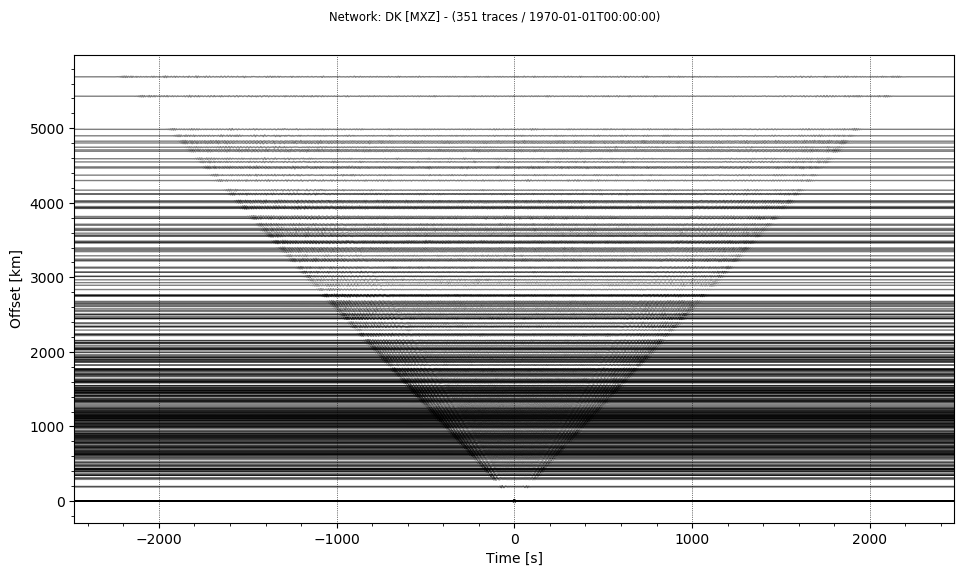

In [19]:
# plot correlations and save the file
corr_homo_path = os.path.join(source_homo_path,"step_0/corr")

# make azimuth selection
traces_homo =plot_section(corr_homo_path,stationlist_path,bandpass = None,comp = 'BHZ',fmt = 'SAC',az_selection = [0,180], 
                      scale = 1., resol = 1,plot=False)

#plot
maxlag = (traces_homo[0].stats.npts-1) / 2.0

traces_homo.plot(type='section',orientation='horizontal',
reftime = traces_homo[0].stats.starttime + maxlag,scale=1.)
plt.show()

traces_homo.plot(type='section',orientation='horizontal',
reftime = traces_homo[0].stats.starttime + maxlag,scale=1.,outfile=os.path.join(project_path,'homo_correlations.png'))


In [20]:
# Setup the Data Source

# Setup a homogeneous source called homo_source
source_data = "data_source"

source_data_path = os.path.join(project_path,source_data)
os.system ('noisi setup_source ' + source_data_path)


print('New source created: ', source_data_path)

New source created:  /Users/jigel/noisi/Alpha_Project/data_source


In [21]:
# Change source_config file
source_config_path = os.path.join(source_data_path,'source_config.json')

with io.open(source_config_path,'r+') as fh:
        conf = json.loads(fh.read())

# change instaseis and wavefield
conf['max_lag'] = 2500
conf['preprocess_do'] = False
conf ['project_name'] = project_name
conf ['project_path'] = project_path
with io.open(source_config_path,'w') as fh:
    cf = json.dumps(conf,sort_keys=False, indent=4, separators=(",", ": "))
    fh.write(cf)

Number of gridpoints:  12512


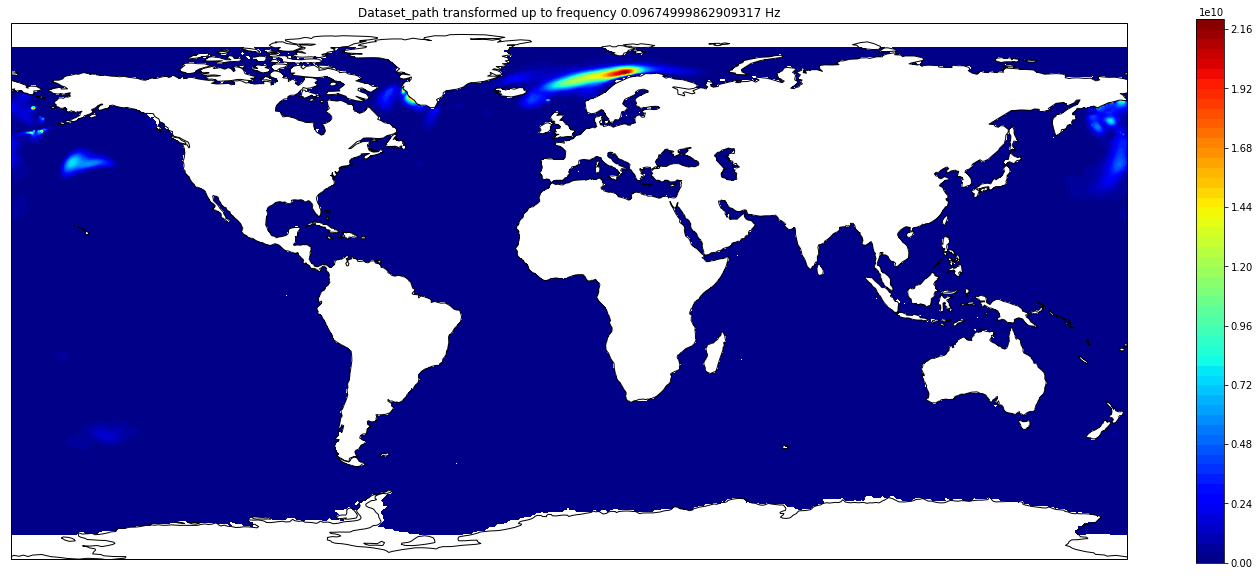

<HDF5 file "UP.ROTU..MXZ.h5" (mode r)>
df = 1.0 nt =  4953 n =  10000
freq_min =  0.0 freq_max =  0.5
Getting ocean mask...
Latitude from -90.0 to 89.85,
        Longitude from -180.0 to 180.0
Sampling grid...
At Gridpoint:  0
At Gridpoint:  1000
At Gridpoint:  2000
At Gridpoint:  3000
At Gridpoint:  4000
At Gridpoint:  5000
At Gridpoint:  6000
At Gridpoint:  7000
At Gridpoint:  8000
At Gridpoint:  9000
At Gridpoint:  10000
At Gridpoint:  11000
At Gridpoint:  12000
Done.


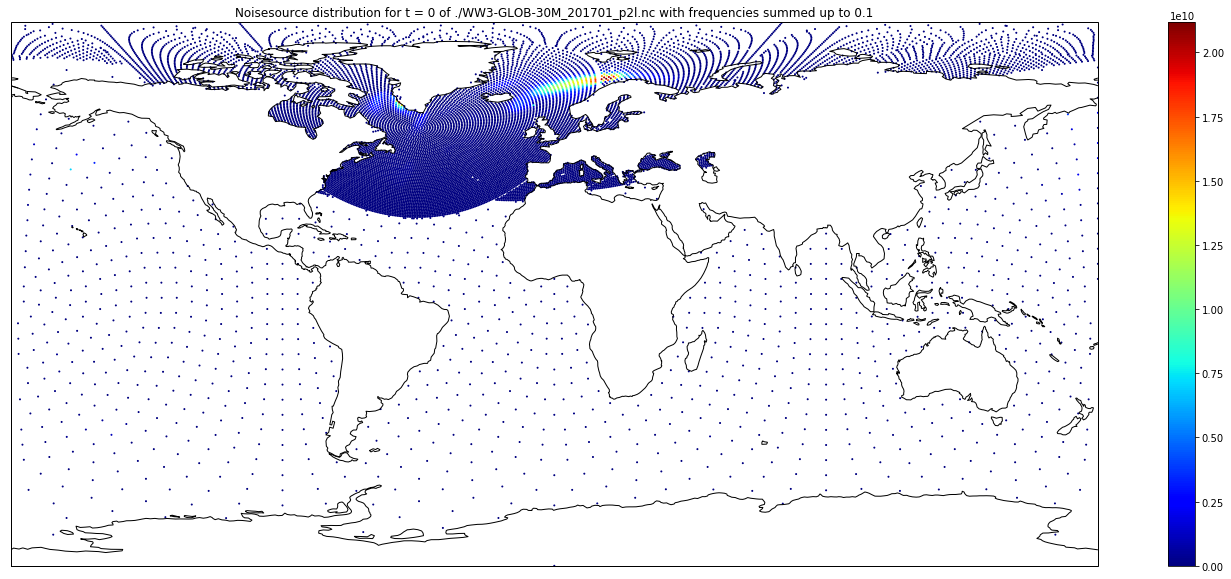

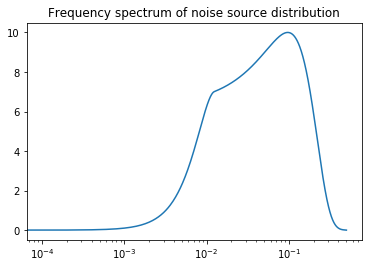

Number of grids:  7
Grid 1 of 7
Grid 2 of 7
Grid 3 of 7
Grid 4 of 7
Grid 5 of 7
Grid 6 of 7
Grid 7 of 7
0 of 23247 voronoi cell surface areas calculated.
1000 of 23247 voronoi cell surface areas calculated.
2000 of 23247 voronoi cell surface areas calculated.
3000 of 23247 voronoi cell surface areas calculated.
4000 of 23247 voronoi cell surface areas calculated.
5000 of 23247 voronoi cell surface areas calculated.
6000 of 23247 voronoi cell surface areas calculated.
7000 of 23247 voronoi cell surface areas calculated.
8000 of 23247 voronoi cell surface areas calculated.
9000 of 23247 voronoi cell surface areas calculated.
10000 of 23247 voronoi cell surface areas calculated.
11000 of 23247 voronoi cell surface areas calculated.
12000 of 23247 voronoi cell surface areas calculated.
13000 of 23247 voronoi cell surface areas calculated.
14000 of 23247 voronoi cell surface areas calculated.
15000 of 23247 voronoi cell surface areas calculated.
16000 of 23247 voronoi cell surface areas cal

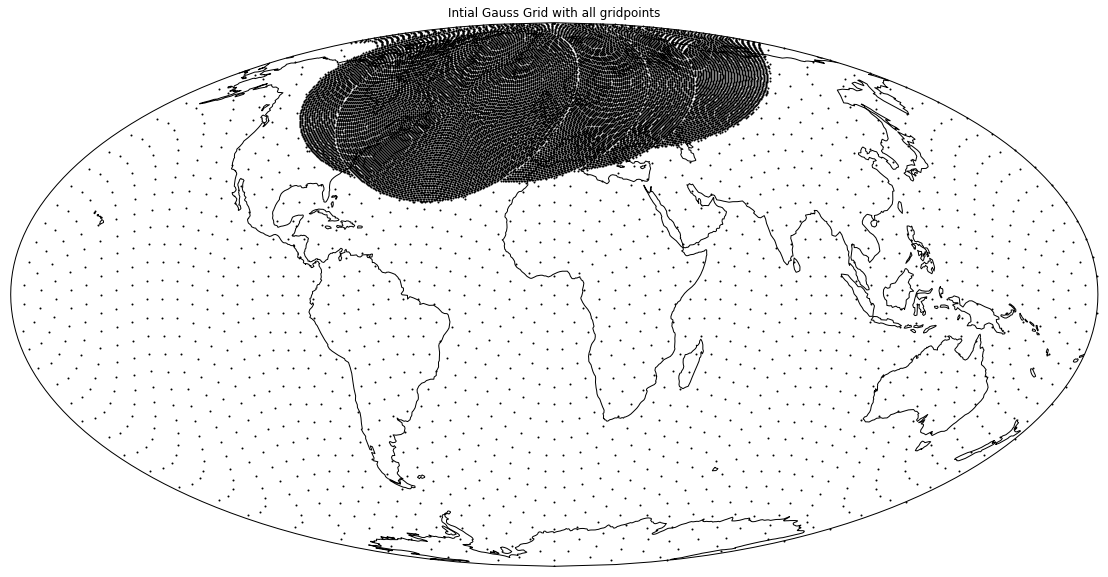

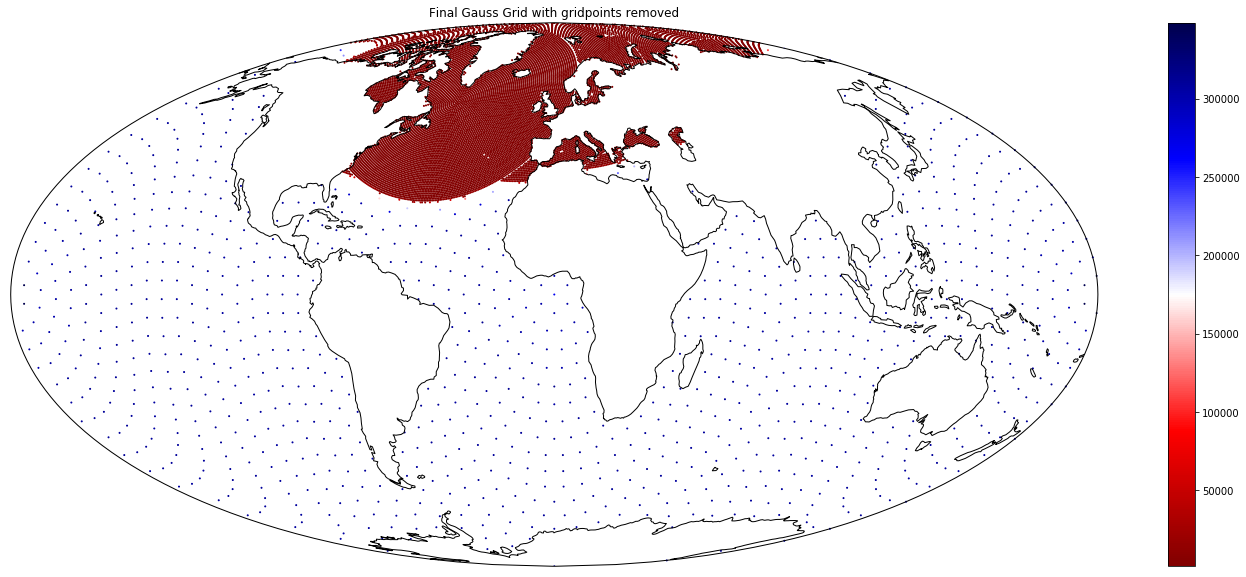

Gridpoints and voronoi cells on land removed.
Final number of gridpoints: 12512


In [22]:
# Setup noise source with data
setup_noisesource_new(project_path,source_data_path,data_path = data_path, t_data = t_data, f_dom = f_dom,outfile=True)

# save file with noise source distribution

In [23]:
# calculate correlations for homogeneous source
print("Computing correlations...")
os.system("mpirun -np 8 noisi correlation {} {}".format(source_data_path,0))
print("All correlations computed.")

Computing correlations...
All correlations computed.


/Users/jigel/noisi/Alpha_Project/data_source/step_0/corr
Found traces:

/Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/GB.CWF..MXZ--GE.VAL..MXZ.sac
...to...
/Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/DK.MUD..MXZ--NS.FOO..MXZ.sac
Assign geographical information.

CWF VAL
52.7383 -1.30722 51.9394 -10.2442
UDBI UDBI
44.5279 15.7644 44.5279 15.7644
BIGH CWF
58.4933 -3.9105 52.7383 -1.30722
FRB SFJD
63.7469 -68.5451 66.9961 -50.62076
DRUM CLL
56.9126 -2.4865 51.30769 13.00261
CWF SOFL
52.7383 -1.30722 62.0689 -6.9658
MONQ VAL
44.3676 1.1953 51.9394 -10.2442
GIMEL BSEG
46.533640000000005 6.26545 53.93531 10.316889999999999
FUORN BIGH
46.62022 10.26352 58.4933 -3.9105
UDBI ISKR
44.5279 15.7644 64.559998 -18.385998999999998
FUORN FUORN
46.62022 10.26352 46.62022 10.26352
SFJD FOO
66.9961 -50.62076 61.598 5.044
CLF CLL
48.02581 2.26 51.30769 13.00261
FOO NSS
61.598 5.044 64.53 11.967
SOFL ISKR
62.0689 -6.9658 64.559998 -18.385998999999998
GIMEL TNS
46.533640000000005 6.2

46.62022 10.26352 70.9866 -8.5057
UDBI NSS
44.5279 15.7644 64.53 11.967
UDBI TNS
44.5279 15.7644 50.2225 8.44731
FUORN EKSU
46.62022 10.26352 57.5726 15.3016
FRB VAL
63.7469 -68.5451 51.9394 -10.2442
MUD FUR
56.455 9.17331 48.1655 11.27633
GIMEL MONQ
46.533640000000005 6.26545 44.3676 1.1953
FUORN IVI
46.62022 10.26352 61.205808 -48.171178000000005
FUORN FRB
46.62022 10.26352 63.7469 -68.5451
MONQ EKSU
44.3676 1.1953 57.5726 15.3016
CLF IVI
48.02581 2.26 61.205808 -48.171178000000005
FRB FUR
63.7469 -68.5451 48.1655 11.27633
MONQ JMIC
44.3676 1.1953 70.9866 -8.5057
EKSU EKSU
57.5726 15.3016 57.5726 15.3016
MUD VAL
56.455 9.17331 51.9394 -10.2442
CLL JMIC
51.30769 13.00261 70.9866 -8.5057
GIMEL SOFL
46.533640000000005 6.26545 62.0689 -6.9658
CWF BSEG
52.7383 -1.30722 53.93531 10.316889999999999
CLL EKSU
51.30769 13.00261 57.5726 15.3016
SOFL VAL
62.0689 -6.9658 51.9394 -10.2442
CWF SFJD
52.7383 -1.30722 66.9961 -50.62076
FRB CWF
63.7469 -68.5451 52.7383 -1.30722
GIMEL CLF
46.53364000000

Trace changed from UDBI--UDBI to UDBI--UDBI.
Trace changed from BIGH--CWF to CWF--BIGH.
Trace changed from FRB--SFJD to SFJD--FRB.
Trace changed from DRUM--CLL to CLL--DRUM.
Trace changed from GIMEL--BSEG to BSEG--GIMEL.
Trace changed from FUORN--FUORN to FUORN--FUORN.
Trace changed from SFJD--FOO to FOO--SFJD.
Trace changed from CLF--CLL to CLL--CLF.
Trace changed from FOO--NSS to NSS--FOO.
Trace changed from GIMEL--TNS to TNS--GIMEL.
Trace changed from GIMEL--NSS to NSS--GIMEL.
Trace changed from CWF--FUR to FUR--CWF.
Trace changed from DRUM--JSA to JSA--DRUM.
Trace changed from MONQ--FUR to FUR--MONQ.
Trace changed from CWF--CWF to CWF--CWF.
Trace changed from DRUM--EKSU to EKSU--DRUM.
Trace changed from VAL--EKSU to EKSU--VAL.
Trace changed from FUR--EKSU to EKSU--FUR.
Trace changed from BSEG--BSEG to BSEG--BSEG.
Trace changed from SFJD--NSS to NSS--SFJD.
Trace changed from CLF--CMSN to CMSN--CLF.
Trace changed from VAL--JMIC to JMIC--VAL.
Trace changed from CWF--CLF to CLF--CWF.
T

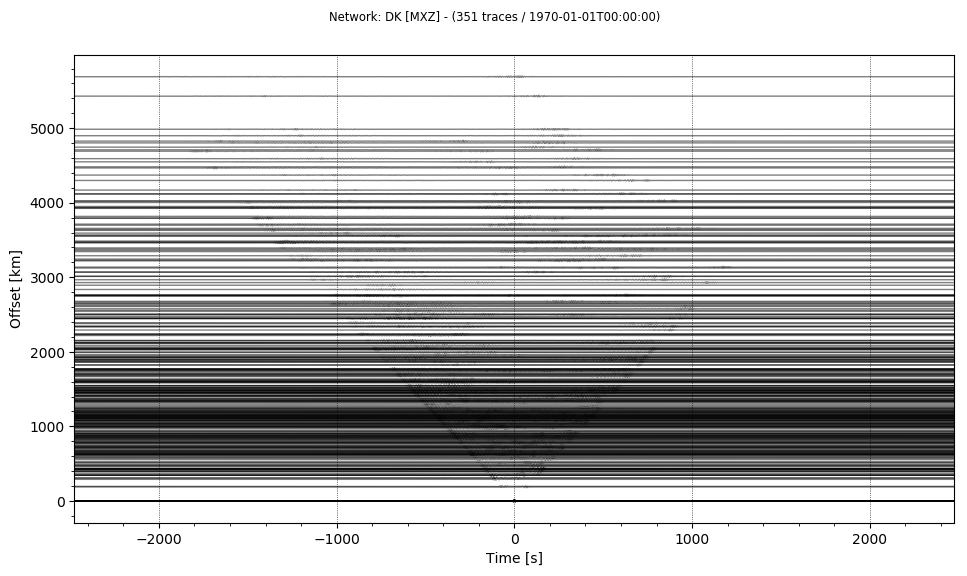

In [24]:
# plot correlations and save the file
corr_data_path = os.path.join(source_data_path,"step_0/corr")

# make azimuth selection
traces_data =plot_section(corr_data_path,stationlist_path,bandpass = None,comp = 'BHZ',fmt = 'SAC',az_selection = [0,180], 
                      scale = 1., resol = 1,plot=False)

#plot
maxlag = (traces_data[0].stats.npts-1) / 2.0

traces_data.plot(type='section',orientation='horizontal', reftime = traces_data[0].stats.starttime + maxlag,scale=1.)
plt.show()

traces_data.plot(type='section',orientation='horizontal', reftime = traces_data[0].stats.starttime + maxlag,scale=1.,outfile=os.path.join(project_path,'data_correlations.png'))



In [25]:
# copy correlations to observed correlations in homo_source
corr_obs_path = os.path.join(source_homo_path,"observed_correlations")

for files in glob(os.path.join(corr_data_path,'*.sac')):
        shutil.copy(files,corr_obs_path)
        print('Copied:',files)

# make synthetic data
make_synth_data(project_name,stationlist_path,corr_obs_path)
print('Synthetic data created.')

Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/GB.CWF..MXZ--GE.VAL..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/CR.UDBI..MXZ--CR.UDBI..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/GB.BIGH..MXZ--GB.CWF..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/CN.FRB..MXZ--IU.SFJD..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/GB.DRUM..MXZ--GR.CLL..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/GB.CWF..MXZ--GB.SOFL..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/FR.MONQ..MXZ--GE.VAL..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/CH.GIMEL..MXZ--GR.BSEG..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/CH.FUORN..MXZ--GB.BIGH..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/CR.UDBI..MXZ--VI.ISKR..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data

Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/IU.SFJD..MXZ--IU.SFJD..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/CH.FUORN..MXZ--GR.CLL..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/GB.SOFL..MXZ--GR.FUR..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/IV.CMSN..MXZ--UP.EKSU..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/CR.UDBI..MXZ--G.IVI..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/IV.CMSN..MXZ--NO.JMIC..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/DK.MUD..MXZ--GB.CWF..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/CN.FRB..MXZ--FR.MONQ..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/CH.FUORN..MXZ--NS.NSS..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data_source/step_0/corr/CH.FUORN..MXZ--GB.SOFL..MXZ.sac
Copied: /Users/jigel/noisi/Alpha_Project/data

Already renamed:  /Users/jigel/noisi/Alpha_Project/homo_source/observed_correlations/GB.JSA..MXZ.GR.CLL..MXZ.Alpha_Project.sac
Already renamed:  /Users/jigel/noisi/Alpha_Project/homo_source/observed_correlations/CH.GIMEL..MXZ.CH.GIMEL..MXZ.Alpha_Project.sac
Already renamed:  /Users/jigel/noisi/Alpha_Project/homo_source/observed_correlations/VI.ISKR..MXZ.VI.ISKR..MXZ.Alpha_Project.sac
Renamed: /Users/jigel/noisi/Alpha_Project/homo_source/observed_correlations/CR.UDBI..MXZ.GB.SOFL..MXZ.Alpha_Project.sac
Already renamed:  /Users/jigel/noisi/Alpha_Project/homo_source/observed_correlations/G.IVI..MXZ.NO.JMIC..MXZ.Alpha_Project.sac
Renamed: /Users/jigel/noisi/Alpha_Project/homo_source/observed_correlations/GB.CWF..MXZ.GR.CLL..MXZ.Alpha_Project.sac
Already renamed:  /Users/jigel/noisi/Alpha_Project/homo_source/observed_correlations/IU.SFJD..MXZ.IU.SFJD..MXZ.Alpha_Project.sac
Already renamed:  /Users/jigel/noisi/Alpha_Project/homo_source/observed_correlations/CN.FRB..MXZ.G.IVI..MXZ.Alpha_Proje

/Users/jigel/noisi/Alpha_Project/homo_source/observed_correlations
Found traces:

/Users/jigel/noisi/Alpha_Project/homo_source/observed_correlations/G.CLF..MXZ.G.CLF..MXZ.Alpha_Project.sac
...to...
/Users/jigel/noisi/Alpha_Project/homo_source/observed_correlations/GB.JSA..MXZ.NS.NSS..MXZ.Alpha_Project.sac


Assign geographical information.

Number of traces:
351


CLF CLF
48.02581 2.26 48.02581 2.26
SOFL EKSU
62.0689 -6.9658 57.5726 15.3016
CMSN JMIC
40.8382 14.1818 70.9866 -8.5057
FRB BIGH
63.7469 -68.5451 58.4933 -3.9105
DRUM JSA
56.9126 -2.4865 49.1879 -2.17089
BSEG CLL
53.93531 10.316889999999999 51.30769 13.00261
UDBI TNS
44.5279 15.7644 50.2225 8.44731
UDBI FOO
44.5279 15.7644 61.598 5.044
DRUM IVI
56.9126 -2.4865 61.205808 -48.171178000000005
MONQ MONQ
44.3676 1.1953 44.3676 1.1953
UDBI VAL
44.5279 15.7644 51.9394 -10.2442
UDBI FUR
44.5279 15.7644 48.1655 11.27633
JSA IVI
49.1879 -2.17089 61.205808 -48.171178000000005
BIGH SOFL
58.4933 -3.9105 62.0689 -6.9658
MONQ EKSU
44.3676 1

MUD SFJD
56.455 9.17331 66.9961 -50.62076
UDBI SOFL
44.5279 15.7644 62.0689 -6.9658
EKSU ISKR
57.5726 15.3016 64.559998 -18.385998999999998
JSA ROTU
49.1879 -2.17089 61.42 15.814
ROTU ISKR
61.42 15.814 64.559998 -18.385998999999998
IVI IVI
61.205808 -48.171178000000005 61.205808 -48.171178000000005
CWF JSA
52.7383 -1.30722 49.1879 -2.17089
FOO ISKR
61.598 5.044 64.559998 -18.385998999999998
BSEG TNS
53.93531 10.316889999999999 50.2225 8.44731
UDBI CLL
44.5279 15.7644 51.30769 13.00261
MONQ DRUM
44.3676 1.1953 56.9126 -2.4865
FUR ROTU
48.1655 11.27633 61.42 15.814
GIMEL ISKR
46.533640000000005 6.26545 64.559998 -18.385998999999998
GIMEL CMSN
46.533640000000005 6.26545 40.8382 14.1818
IVI NSS
61.205808 -48.171178000000005 64.53 11.967
FUORN JMIC
46.62022 10.26352 70.9866 -8.5057
EKSU EKSU
57.5726 15.3016 57.5726 15.3016
BIGH JSA
58.4933 -3.9105 49.1879 -2.17089
FUORN BSEG
46.62022 10.26352 53.93531 10.316889999999999
BSEG FUR
53.93531 10.316889999999999 48.1655 11.27633
BSEG FOO
53.93531

In [26]:
# noisi measurement
print('Computing adjoint sources...')
os.system('noisi measurement {} {}'.format(source_homo_path,0))
print('Done.')

Computing adjoint sources...
Done.


In [27]:
# Compute kernels
print('Computing kernels...')
os.system('mpirun -np 8 noisi kernel {} {}'.format(source_homo_path,0))
print('Done.')

Computing kernels...
Done.


In [28]:
# Compute gradient
print('Computing gradient...')
os.system('noisi gradient {} {}'.format(source_homo_path,0))
print('Done.')

Computing gradient...
Done.


ValueError: c of shape (3897,) not acceptable as a color sequence for x with size 12512, y with size 12512

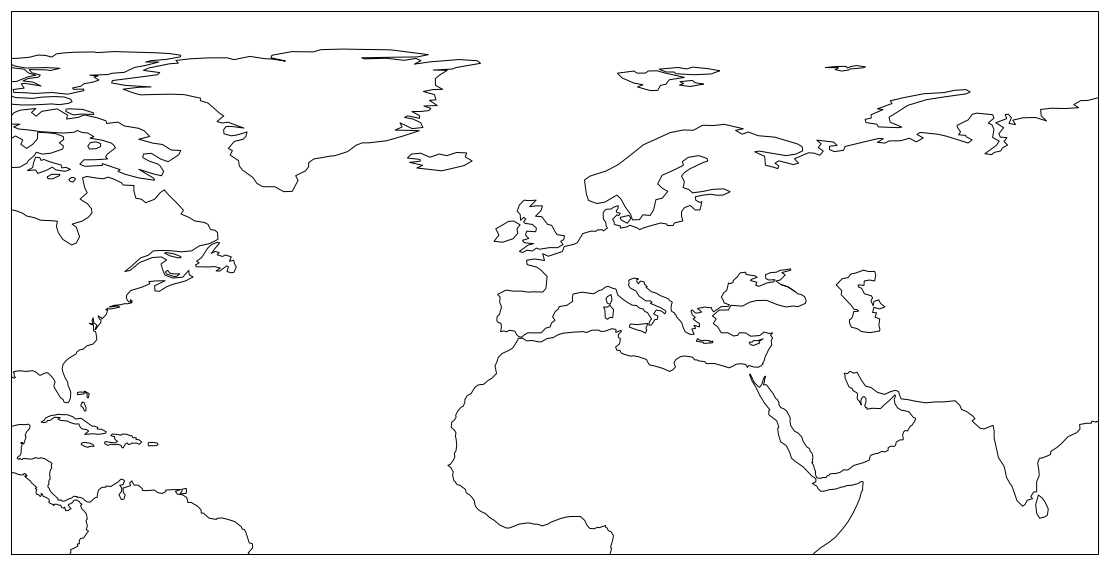

In [30]:
# Plot Gradient
plot_gradient(project_path,source_homo_path,extent=extent)
# save file
plt.savefig(os.path.join(project_path,"data_gradient.png"))

